# Grayscale to RGB - Código de Treinamento

Este notebook contém o pipeline utilizado para treinar a Rede Neural Convolucional a aprender a converter imagens em escalas de cinza para RGB, como parte do projeto realizado para a disciplina de Processamento de Imagens da Universidade de São Paulo.

Neste notebook, iremos treinar o modelo especificado no repositório https://github.com/RodrigoArboleda/Grayscale-to-RGB.

## Dataset

Os datasets utilizados neste treinamento, são provenientes da base de dados CIFAR10 e Linnaeus 5.

## Saida Gerada

Este notebook gerara como saida alguns exemplos de imagens criadas pela rede, os gráficos da função de custo ao decorrer das epocas, e para o uso da rede posteriormente, o arquivo que armazena os pesos da rede, e os parametros MEAN e STD do conjunto de treino, pois são necessários para conseguir utilizar a rede posteriormente.

O arquivo que armazena os pesos da rede é definido com o nome "model_state", se tiver algum arquivo com o mesmo nome no folder que se encontra este notebook, o mesmo sera sobrescrito.

## Integrantes do Grupo

Luan Ícaro Pinto Arcanjo - 10799230

Victor Graciano de Souza Correia - 10431201

Rodrigo Cesar Arboleda - 10416722

## Instalando Bibliotecas

Abaixo esta todas as bibliotecas utilizadas ao decorrer de todo o projeto.

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dataset_loader
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from skimage.io import imread_collection

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
batch_size = 100

## Carregando e Tratando o Dataset

Nos blocos de código abaixo, estamos defindo funções auxiliares, e principalmente, carregando e tratando o dataset para realizar o treinamento

In [ ]:
'''
Esta funcao plota um conjunto de imagens passadas por parametro, ela plota 
apenas um numero quadrado de imagens, se for passado uma quantidade não quadrada,
ira plotar apenas uma quantidade de imagens equivalente ao numero quadrado mais
proximo por baixo da quantidade de imagens passada.
@PARAMETROS
  image_vector - o conjutno de imagens a ser plotado
  color - indica se as imagens sao RGB ou em escalas de cinza.
    0 - escalas de cinza
    1 - RGB
'''
def image_plot(image_vector, color):
  size = image_vector.shape[0]
  size = int(size**(1/2))
  f, ax = plt.subplots(size,size)
  for i in range(size):
    for j in range(size):
      if color:
        ax[i,j].imshow(image_vector[i*size+j].astype(np.uint8))
      else:
        ax[i,j].imshow(image_vector[i*size+j,:,:,0].astype(np.uint8), cmap='gray', vmin=0, vmax=255)

In [ ]:
'''
Esta funcao converte um conjunto de imagens que estao na
forma image_collection para o formato numpy
@PARAMETROS
  images - conjunto de imagens no formato image_collection
@RETORNO
  images_RGB - images no formato numpy
'''
def image_collection_to_numpy( images ):
    images_RGB = np.zeros( (len(images),32,32,3), )

    for i in range( len(images) ):
        images_RGB[i] = images[i] 
    
    return images_RGB.astype(np.float32)

In [ ]:
'''
Esta funcao transforma um conjunto de imagem RGB para grayscale, atraves da 
formula:
  GRAY =  0.299*R  + 0.587*G + 0.114*B
E deixa as imagens em grayscale já preparada para transformar em torch tensors.
@PARAMETROS
  images_RGB - imagens RGB a serrem convertidas.
@RETORNO
  images_GRAY - imagens em escalas de cinza criadas.
'''
def transform_to_gray( images_RGB ):

    R = images_RGB[:, :, :,0]
    G = images_RGB[:, :, :,1]
    B = images_RGB[:, :, :,2]

    images_GRAY =  0.299*R  + 0.587*G + 0.114*B 

    return images_GRAY.reshape( images_RGB.shape[0],32,32,1 )

In [ ]:
#definindo os patchs do conjunto de treino e de validacao
path_train = './../input/data-pdi/data/train/*.jpg'
path_val = './../input/data-pdi/data/test/*.jpg'

#carregando o conjunto de treino e validacao, no formato image collection
train = imread_collection(path_train)
val = imread_collection(path_val)


In [ ]:
#transformando para numpy
train_RGB = image_collection_to_numpy(train)
val_RGB = image_collection_to_numpy(val)

In [ ]:
'''
Esta funcao faz um embaralhamento das imagens, para resolver a questao
de todasa as imagens da mesma categoriza estarem unidos, com o intuito
de melhoram a qualidade dos batchs.
@PARAMETORS
  images_RGB - imagem a serem embaralhadas.
@RETORNO
  aux - imagens embaralhadas.
'''
def shuffle_images(images_RGB):

    idx = np.arange( train_RGB.shape[0] )
    np.random.shuffle(idx)
    
    aux = np.zeros( train_RGB.shape )
    
    for i in range( train_RGB.shape[0] ):
        aux[ i, :, :, :] = images_RGB[ idx[i], :, :, :]

    return aux

In [ ]:
#fazendo o embaralhamento do conjunto de treino
train_RGB = shuffle_images(train_RGB)

In [ ]:
#pegando a imagens dos conjunto em escalas de cinza
train_GRAY = transform_to_gray(train_RGB)
val_GRAY = transform_to_gray(val_RGB)

In [ ]:
'''
Esta funcao separa um conjunto de par de imagens ( gray e RGB) em batchs,
os tamanhos dos batchs sao definidos pelo batch_size, o tamanho do batch 
deve ser divisivel pelo tamanho do conjunto.
@PARAMETROS
    images_GRAY - conjunto das imagens em escalas de cinza
    images_RGB - conjunto das imagens em RGB.
    batch_size - tamanho dos batchs.
@RETORNO
    img_G_batchs - conjunto das imagens em escalas de cinza separados em batches.
    img_RGB_batchs - conjunto das imagens RGB separados em batches.
'''
def transform_in_batches(images_GRAY, images_RGB, batch_size):
    #pegando o numero de batches
    img_G_batchs = np.array(  [ images_GRAY[_ix : _ix+batch_size] for _ix in range(0, images_GRAY.shape[0], batch_size)  ]  )
    img_RGB_batchs = np.array(  [ images_RGB[_ix : _ix+batch_size] for _ix in range(0, images_RGB.shape[0], batch_size)  ]  )

    return img_G_batchs, img_RGB_batchs

#
train_GRAY_b, train_RGB_b = transform_in_batches(train_GRAY, train_RGB, batch_size)
val_GRAY_f, val_RGB_f = transform_in_batches( val_GRAY, val_RGB, batch_size )

In [ ]:
'''
Esta funcao envia as imagens cria os torch tensors do conjunto de imagens,
atraves das imagens em numpy, e envia os dados para GPU
@PARAMETROS
  data - conjunto de imagens.
  batch_size - tamanho do batch definido.
@RETORNO
  torch tensor - torch tensor das imagens passadas como parametro.
'''
def transform_and_create_torch_tensors(data, batch_size):
    
    data = torch.from_numpy(data).float().cuda()
    return data.contiguous().view(data.size(0),batch_size,-1,32,32)

In [ ]:
#verificando se existe uma GPU seu suporta CUDA
!nvidia-smi

Sat Jul 10 07:53:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#criando os torch tensors do conjunto de treino e validacao e enviando os dados 
#para GPU.
train_GRAY_tensor = transform_and_create_torch_tensors(train_GRAY_b, batch_size)
train_RGB_tensor = transform_and_create_torch_tensors(train_RGB_b, batch_size)

val_GRAY_tensor = transform_and_create_torch_tensors(val_GRAY_f, batch_size)
val_RGB_tensor = transform_and_create_torch_tensors(val_RGB_f, batch_size)

In [ ]:
#Pegando a media e o desvio padrao do conjunto de treino
MEAN = torch.mean( train_GRAY_tensor[:,:,0,:,:] )
STD = torch.mean( train_GRAY_tensor[:,:,0,:,:] )

#normalizando os conjutos de imagens, as imagens em escalas de cinza
#sao normlizadas para terem media 0, e desvio padrao 1, enquanto as
#imagen RGB sao normalizadas para os valores estarem no intervalo [0,1]
train_GRAY_tensor[:,:,0,:,:] = (train_GRAY_tensor[:,:,0,:,:]-MEAN)/STD
train_RGB_tensor /= 255

val_GRAY_tensor[:,:,0,:,:] = (val_GRAY_tensor[:,:,0,:,:]-MEAN)/STD
val_RGB_tensor /= 255

## Definindo a Arquitetura da Rede Neural Convolucional

Nos blocos de código abaixo, esta o código em pytorch que condiz com a arquitetura proposta.

In [ ]:
'''
Funcao auxiliar para definir a arquitetura da rede,
esta funcao retorna um pipeline sequencial de seguinte sequencia:
  Camada de convolucao - out_c filtros de tamanho 3x3 com padding 1.
  ReLU
  Camada de convolucao - out_c filtros de tamanho 3x3 com padding 1.
  ReLU
O que iremos definir por conveniencia como convolucao dupla.
@PARAMETROS
  in_C - profundidade de entrada da convolucao dupla.
  out_c - profundidade de saida da convolucao dupla.
'''
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)

    )

    return conv

In [ ]:
'''
Funcao que define a arquitetura da rede neural, como especificado no README do
repositorio https://github.com/RodrigoArboleda/Grayscale-to-RGB
'''
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = double_conv(1,32)
        self.conv2 = double_conv(32,64)
        self.conv3 = double_conv(64,64)
        self.linear1 = nn.Linear(64*8*8, 1024)
        self.linear2 = nn.Linear(1024, 3072)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, image):
        #taking batch_size
        batch_size = image.size()[0]
        # Encoder Phase
        x1 = self.conv1(image)
        x2 = self.max_pool(x1)
        
        x3 = self.conv2(x2)
        x4 = self.max_pool(x3)
        
        x5 = self.conv3(x4)
        # Decoder Phase
        x6 = self.linear1(x5.view(batch_size,-1))
        
        f1 = F.relu(x6)
        f2 = torch.sigmoid(self.linear2(f1)).view(-1, 3, 32, 32)
        return f2

## Treinando a Rede Neural Convolucional

Nos blocos de código abaixo, estamos realizando o treinamento da rede, como definindo os hiperparametros do treinamento.

In [ ]:
#definindo os hiperparametros de learning rate e numero de epocas.
learning_rate = 0.0001
epochs = 2000

# Inicializando a rede neural e a funcao de custo.
loss = nn.MSELoss()
model = CNN()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
#definindo os arrays que armazenam a funcao de custo do conjunto 
#de treino e de validacao ao decorrer das epocas
train_loss_array = []
val_loss_array = []

#loop, treinado por "epochs" epocas.
for e in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    #iterando sobre os batchs do conjunto de teste
    for batch, train_data in enumerate(train_GRAY_tensor):
        
        #definindo a entrada da rede como x.
        x = train_data
        #definindo a saida desejada como y.
        y = train_RGB_tensor[batch]
        
        #zerando o gradiente
        optimizer.zero_grad()
        
        #avaliando o modelo em x
        y_hat = model(x)
        #calculando a loss entre y e y_hat
        loss_batch = loss(y_hat, y)
        train_loss += loss_batch.item()
        #movendo a rede na direcao do gradiente, utilizando o 
        #optimizer
        loss_batch.backward()
        optimizer.step()
    
    #nao permitindo atulizar os gradientes dentro do escopo do with
    with torch.no_grad():
        #iterando sobre os batchs do conjunto de validacao
        for batch, val_data in enumerate(val_GRAY_tensor):
            
            #definindo a entrada da rede como x.
            x = val_data
            #definindo a saida desejada como y.
            y = val_RGB_tensor[batch]
            
            #avaliando o modelo em x
            y_hat = model(x)
            #calculando a loss entre y e y_hat
            loss_test = loss(y_hat, y)
            val_loss += loss_test.item()
    
    #printando a loss do conjunto de treino e de validacao
    train_loss_array.append(train_loss)
    val_loss_array.append(val_loss)
    print('\rEPOCH: {} | Train_loss: {} | Validation_loss: {}'.format(e, train_loss, val_loss), end='')

print('\nFinished Training')

EPOCH: 1999 | Train_loss: 0.9207907309755683 | Validation_loss: 1.2816698541864753
Finished Training


## Plotando a Função de Custo

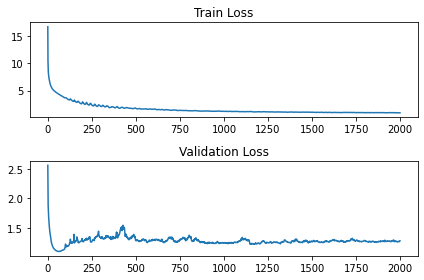

In [ ]:
#plotando a funcao de custo do treino e do conjunto de validacao ao decorrer das epocas.
f, ax = plt.subplots(2,1)
ax[0].set_title('Train Loss')
ax[0].plot(train_loss_array)
ax[1].set_title('Validation Loss')
ax[1].plot(val_loss_array)
f.tight_layout()
plt.show()

## Plotando Imagens de Exemplo

In [ ]:
#armazenando o resultado da rede para o primeiro batch size
img =  model(val_GRAY_tensor[0])

In [ ]:
#ira plotar qtd_plot*qtd_plot imagens
qtd_plot = 3

#definindo as matrizes numpy que armazenaram as imagens que desejamos plotar
imgs_gray = np.zeros( (qtd_plot*qtd_plot, 32, 32, 1) )
imgs_RGB = np.zeros( (qtd_plot*qtd_plot, 32, 32, 3) )
imgs_cnn = np.zeros( (qtd_plot*qtd_plot, 32, 32, 3) )

for i in range(qtd_plot):
    for j in range(qtd_plot):
        #restaurando a imagem em escalas de cinza criada no inicio do notebook
        tmp = MEAN.item()+val_GRAY_tensor[i][j].detach().cpu().squeeze().numpy()*STD.item()
        imgs_gray[i*qtd_plot + j,:,:,:] = tmp.reshape(32,32,1).astype(np.uint8)
        #restaurando a imagem RGB criada pela rede.
        tmp = val_RGB_tensor[i][j].detach().cpu().numpy()*255
        imgs_RGB[i*qtd_plot + j,:,:,:] = tmp.reshape(32,32,3).astype(np.uint8)
        #restaurando a imagem RGB original.
        tmp = model(val_GRAY_tensor[i])[j].detach().cpu().numpy()*255
        imgs_cnn[i*qtd_plot + j,:,:,:] = tmp.reshape(32,32,3).astype(np.uint8)

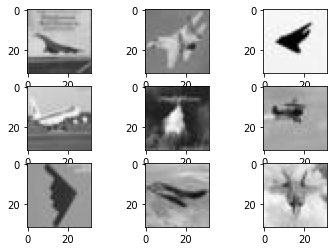

In [ ]:
#plotando o conjunto de imagens em escalas de cinza
image_plot(imgs_gray, 0)

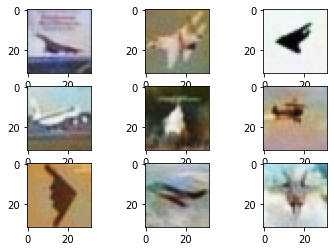

In [ ]:
#plotando o conjunto de imagens RGB criadas pela rede neural
image_plot(imgs_cnn, 1)

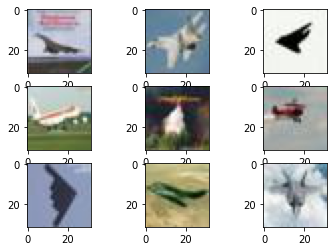

In [ ]:
#plotando o conjunto de imagens RGB real.
image_plot(imgs_RGB, 1)

## Salvando a Rede Neural Convolucional.

Nestes dois ultimos blocos de código, estamos salvando a rede neural no arquivo model_state, e printando os valores de MEAN e STD, para os termos salvos no notebook, para serem utilizados posteriormente.

In [ ]:
#salvando os pesos da rede neural no arquivo model_state
torch.save(model.state_dict(), "./model_state")

In [ ]:
#printando os parametros MEAN e STD, pois e necessario guarda-los
#ao utilizar a rede posteriormente.
print(MEAN.item())
print(STD.item())

121.88642883300781
121.88642883300781
